In [1]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
from geopandas import GeoDataFrame
from shapely.geometry import shape
from shapely.geometry import Point
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
import shapely
import shapely.wkt
import math

In [2]:
# importo el dataset
df = pd.read_csv('properatti.csv')
# importo las coordenadas de los barrios de la Capital Federal
barrios = pd.read_csv('barrios.csv', encoding = 'latin')

In [3]:
# chequeo columnas redundantes
for column in df.columns:
    if len(df[column].unique()) <= 1:
        print(column, df[column].unique())

operation ['sell']
country_name ['Argentina']


In [4]:
# elimino las columnas que son irrelevantes
df.drop(df[['Unnamed: 0','place_name','country_name','state_name','operation', 'properati_url','image_thumbnail']], axis = 1, inplace = True)
# elimino las filas que no corresponden con el tipo de propiedad = Departamento
df.drop(df[df['property_type'] != 'apartment'].index, axis = 0, inplace = True)
# elimino las filas que no corresponden con el tipo de moneda = Dólares
df.drop(df[df['currency'] != 'USD'].index, axis = 0, inplace = True)

In [5]:
# genero una lista de listas con el pais, el estado y el barrio
ls = [i.split('|') for i in df['place_with_parent_names']]

In [6]:
# instancio 3 listas vacias para cada variable dentro de la lista de listas
country = []
state = []
neighbourhood = []

# recorro cada lista dentro de la lista grande e incorporo la variable correspondiente a la nueva lista vacía
for i in ls:
    country.append(i[1])
    state.append((i[2]))
    neighbourhood.append((i[3]))

In [7]:
# creo una nueva columna dentro del dataset con las nuevas variables (pais, estado y barrio)
df['country'] = country
df['state'] = state
df['neighbourhood'] = neighbourhood

In [8]:
# decido quedarme con los estados que son sólo Capital Federal y que no tengan precio por metro cuadrado vacío
df = df[pd.notnull((df['price_usd_per_m2'])) & (df['state'] == 'Capital Federal')]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18922 entries, 2 to 121219
Data columns (total 22 columns):
property_type                 18922 non-null object
place_with_parent_names       18922 non-null object
geonames_id                   18027 non-null float64
lat-lon                       13913 non-null object
lat                           13913 non-null float64
lon                           13913 non-null float64
price                         18922 non-null float64
currency                      18922 non-null object
price_aprox_local_currency    18922 non-null float64
price_aprox_usd               18922 non-null float64
surface_total_in_m2           18922 non-null float64
surface_covered_in_m2         18045 non-null float64
price_usd_per_m2              18922 non-null float64
price_per_m2                  18043 non-null float64
floor                         1278 non-null float64
rooms                         9316 non-null float64
expenses                      5558 non-null floa

In [10]:
# reseteo el índice para luego tener una mejor referencia
df = df.reset_index()

In [11]:
# me fijo que lo hecho antes haya funcionado
df[['place_with_parent_names','country','state','neighbourhood']].head(10)

,place_with_parent_names,country,state,neighbourhood
0,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,Mataderos
1,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,Belgrano
2,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,Belgrano
3,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,Palermo
4,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,Palermo
5,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,Palermo
6,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,Palermo
7,|Argentina|Capital Federal|Flores|,Argentina,Capital Federal,Flores
8,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,Boedo
9,|Argentina|Capital Federal|Las Cañitas|,Argentina,Capital Federal,Las Cañitas


In [12]:
# elimino las columnas que ya no me sirven
df.drop(df[['place_with_parent_names','country']], axis = 1, inplace = True)

In [13]:
# reemplazo valores vacíos por un NaN de Numpy
df['state'].replace('',np.nan, inplace = True)
df['neighbourhood'].replace('', np.nan, inplace = True)

In [14]:
# creo una lista con los nombres de las columnas del dataset
cols = df.columns.tolist()
# reordeno las columnas
cols = [cols[-2]] + [cols[-1]] + cols[:-2]
# asigno el nuevo orden de columnas al dataset
df = df[cols]

In [15]:
# redondeo a 2 decimales los valores de precio por m2
df['price_usd_per_m2'] = df['price_usd_per_m2'].round(decimals = 2)
df['price_per_m2'] = df['price_per_m2'].round(decimals = 2)

In [16]:
# paso el texto dentro de la descripción y el título a minúsculas para no tener problemas luego
df['description'] = df['description'].str.lower()
df['title'] = df['title'].str.lower()

In [17]:
# extraigo los numeros que están antes de la palabra amb|ambiente|ambientes| y lo asigno a los valores vacíos de la columna rooms
df['rooms'].fillna(df['description'].str.extract('(\d)\samb*', expand = False),inplace = True)
# extraigo la cantidad de ambientes en letras y lo asigno a los valores vacíos de la columna rooms
df['rooms'].fillna(df['description'].str.extract('(un|dos|tres|cuatro|cinco|seis)\samb*',expand = False),inplace = True)
# extraigo la palabra 'monoambiente' y la asigno a los valores vacíos de la columna rooms
df['rooms'].fillna(df['description'].str.extract('(monoambiente)', expand = False), inplace = True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18922 entries, 0 to 18921
Data columns (total 21 columns):
state                         18922 non-null object
neighbourhood                 18567 non-null object
index                         18922 non-null int64
property_type                 18922 non-null object
geonames_id                   18027 non-null float64
lat-lon                       13913 non-null object
lat                           13913 non-null float64
lon                           13913 non-null float64
price                         18922 non-null float64
currency                      18922 non-null object
price_aprox_local_currency    18922 non-null float64
price_aprox_usd               18922 non-null float64
surface_total_in_m2           18922 non-null float64
surface_covered_in_m2         18045 non-null float64
price_usd_per_m2              18922 non-null float64
price_per_m2                  18043 non-null float64
floor                         1278 non-null float6

In [19]:
# creo un diccionario para luego mapear la cantidad de ambientes (en números) con la cantidad de ambientes en letras
roomsMap = { 
    "un": 1,
    "dos": 2, 
    "tres": 3,
    "cuatro": 4, 
    "cinco": 5,
    "seis": 6, 
    "monoambiente": 1 
            }

In [20]:
# aplico el mapping
df['ambientes1'] = df['rooms'].map(roomsMap)
# creo una nueva columna que es la conjunción de rooms y ambientes1
df['ambientes2'] = df['ambientes1'].fillna(df['rooms'])

In [21]:
# elimino rooms y ambientes1 porque ambientes2 tiene la info de ambas
df.drop(df[['rooms','ambientes1']], axis = 1, inplace = True)

In [22]:
# renombro ambientes2 a rooms
df = df.rename(columns = {'ambientes2': 'rooms'})
# elimino la columna index que no sirve
df.drop(df[['index']], axis = 1, inplace = True)

In [23]:
# asigno la latitud media de cada barrio a los valores vacíos dentro de la columna Lat
df['lat'].fillna(df.groupby('neighbourhood')['lat'].transform('mean'), inplace = True)
# asigno la longitud media de cada barrio a los valores vacíos dentro de la columna Lon
df['lon'].fillna(df.groupby('neighbourhood')['lon'].transform('mean'), inplace = True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18922 entries, 0 to 18921
Data columns (total 20 columns):
state                         18922 non-null object
neighbourhood                 18567 non-null object
property_type                 18922 non-null object
geonames_id                   18027 non-null float64
lat-lon                       13913 non-null object
lat                           18712 non-null float64
lon                           18712 non-null float64
price                         18922 non-null float64
currency                      18922 non-null object
price_aprox_local_currency    18922 non-null float64
price_aprox_usd               18922 non-null float64
surface_total_in_m2           18922 non-null float64
surface_covered_in_m2         18045 non-null float64
price_usd_per_m2              18922 non-null float64
price_per_m2                  18043 non-null float64
floor                         1278 non-null float64
expenses                      5558 non-null float

/Users/ncarrascosa/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


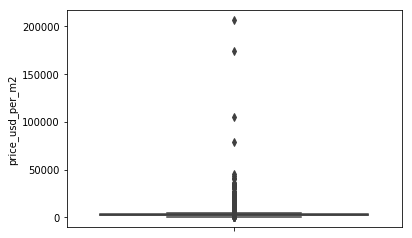

In [25]:
# creo un boxplot para ver si hay outliers
sns.boxplot(y="price_usd_per_m2", data=df)

In [26]:
def remove_outlier(df_in, col_name):
    """accept a dataframe, removes outliers, returns cleaned data in a new dataframe"""
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df = remove_outlier(df, 'price_usd_per_m2')

/Users/ncarrascosa/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


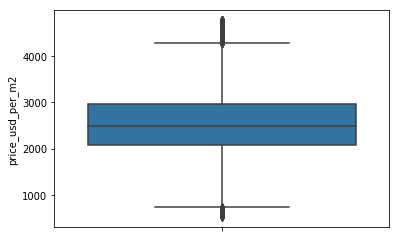

In [27]:
sns.boxplot(y="price_usd_per_m2", data=df)

In [28]:
# decido quedarme con las filas que los precios menores a 5100
#df = df[df['price_usd_per_m2'] < 5000]

In [29]:
# elimino las filas que tienen superficie total menor o igual a superficie cubierta
df = df[df['surface_total_in_m2'] >= df['surface_covered_in_m2']]

In [30]:
# elimino las filas que tienen precios por metro cuadrado menor a 400
#df = df[df['price_usd_per_m2'] >= 400] 

In [31]:
# creo otro boxplot para ver como afectaron los filtro que apliqué antes
#sns.boxplot(y="price_usd_per_m2", data=df)

/Users/ncarrascosa/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


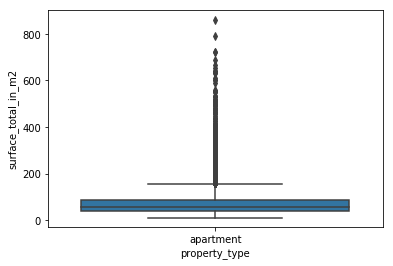

In [32]:
# creo un boxplot para ver los outliers en términos de superficie total por tipo de propiedad
sns.boxplot(y="surface_total_in_m2",x="property_type", data=df)

In [33]:
df = remove_outlier(df, 'surface_total_in_m2')

/Users/ncarrascosa/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


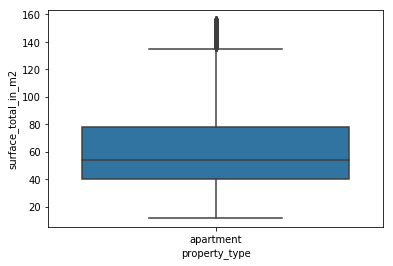

In [34]:
sns.boxplot(y="surface_total_in_m2",x="property_type", data=df)

In [35]:
# elimino las filas que tienen superficie total mayor a 1000mts2
#df = df[(df['surface_total_in_m2'] <1000)]

In [36]:
# boxplot para ver el efecto del filtro anterior
#sns.boxplot(y="surface_total_in_m2",x="property_type", data=df, color = 'green')

In [37]:
#def find_outliers(property_type):
    #Esta función lo que hace es asignar un valor constante 
    #como outlier dependiendo del tipo de propiedad
    
#    if property_type == 'apartment':
#        return 200

#def compute_outliers(property_type, surface):
    #Esta función computa el valor de la superficie 
    #dependiendo si es outlier o no

#    high_surface = find_outliers(property_type)
#    if surface <  high_surface:
#        return surface
#    else:
#        return high_surface

In [38]:
# elimino los outliers aplicando las funciones anteriormente creadas
#df['surface_total_in_m2'] = df.apply(lambda row: compute_outliers(row['property_type'],row['surface_total_in_m2']),axis=1)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14963 entries, 0 to 18921
Data columns (total 20 columns):
state                         14963 non-null object
neighbourhood                 14681 non-null object
property_type                 14963 non-null object
geonames_id                   14296 non-null float64
lat-lon                       11421 non-null object
lat                           14806 non-null float64
lon                           14806 non-null float64
price                         14963 non-null float64
currency                      14963 non-null object
price_aprox_local_currency    14963 non-null float64
price_aprox_usd               14963 non-null float64
surface_total_in_m2           14963 non-null float64
surface_covered_in_m2         14963 non-null float64
price_usd_per_m2              14963 non-null float64
price_per_m2                  14961 non-null float64
floor                         1123 non-null float64
expenses                      4509 non-null float

In [40]:
# elimino columnas que no me sirven
df.drop(df[['state','geonames_id','surface_covered_in_m2','price_per_m2','currency','price_aprox_local_currency','floor']], 
        axis = 1, 
        inplace = True)

In [41]:
np.sum(df['expenses'].isnull())

10454

/Users/ncarrascosa/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


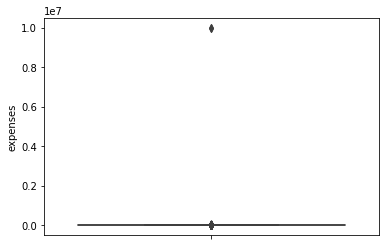

In [42]:
sns.boxplot(y="expenses", data=df)

In [43]:
# asigno el promedio de expensas de cada barrio a los valores vacíos dentro de la columna expenses
df['expenses'].fillna(df.groupby('neighbourhood')['expenses'].transform('mean'), inplace = True)

In [44]:
df['expenses'] = df['expenses'].round(decimals = 0)

In [46]:
df = remove_outlier(df, 'expenses')

/Users/ncarrascosa/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


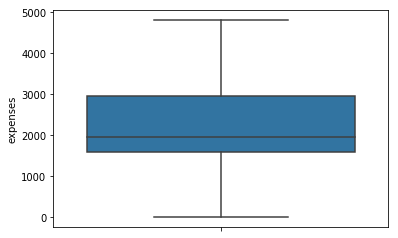

In [47]:
sns.boxplot(y = 'expenses', data=df)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14089 entries, 0 to 18921
Data columns (total 13 columns):
neighbourhood          13998 non-null object
property_type          14089 non-null object
lat-lon                10844 non-null object
lat                    14060 non-null float64
lon                    14060 non-null float64
price                  14089 non-null float64
price_aprox_usd        14089 non-null float64
surface_total_in_m2    14089 non-null float64
price_usd_per_m2       14089 non-null float64
expenses               14089 non-null float64
description            14089 non-null object
title                  14089 non-null object
rooms                  12444 non-null object
dtypes: float64(7), object(6)
memory usage: 1.5+ MB


In [50]:
df.reset_index(inplace = True)

In [51]:
def get_rooms_by_median(row):
        surface_total = int(row['surface_total_in_m2'])
        
        rooms_1_median = df[df['rooms'] == 1]['surface_total_in_m2'].median()
        rooms_2_median = df[df['rooms'] == 2]['surface_total_in_m2'].median()
        rooms_3_median = df[df['rooms'] == 3]['surface_total_in_m2'].median()
        rooms_4_median = df[df['rooms'] == 4]['surface_total_in_m2'].median()
        rooms_5_median = df[df['rooms'] == 5]['surface_total_in_m2'].median()
        rooms_6_median = df[df['rooms'] == 6]['surface_total_in_m2'].median()
        
        if surface_total <= rooms_1_median:
            return 1
        elif rooms_1_median < surface_total <= rooms_2_median:
            return 2
        elif rooms_2_median < surface_total <= rooms_3_median:
            return 3
        elif rooms_3_median < surface_total <= rooms_4_median:
            return 4
        elif rooms_4_median < surface_total <= rooms_5_median:
            return 5
        else:
            return 6
        return row['rooms']

In [52]:
df['rooms'].fillna(df.apply(get_rooms_by_median, axis = 1), inplace = True)

In [53]:
np.sum(df['rooms'].isnull())

0

In [54]:
df['rooms'] = df['rooms'].astype(int)

In [55]:
df['rooms'].value_counts()

2    4254
1    3809
3    3645
4    2038
5     242
6      89
7       8
8       3
0       1
Name: rooms, dtype: int64

In [56]:
df = df[(df['rooms'] < 7) & (df['rooms'] !=0)]

In [57]:
df = df[(pd.notnull((df['lat']))) & (pd.notnull((df['lon']))) & (pd.notnull((df['neighbourhood']))) & pd.notnull((df['expenses']))]

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13987 entries, 0 to 14087
Data columns (total 14 columns):
index                  13987 non-null int64
neighbourhood          13987 non-null object
property_type          13987 non-null object
lat-lon                10771 non-null object
lat                    13987 non-null float64
lon                    13987 non-null float64
price                  13987 non-null float64
price_aprox_usd        13987 non-null float64
surface_total_in_m2    13987 non-null float64
price_usd_per_m2       13987 non-null float64
expenses               13987 non-null float64
description            13987 non-null object
title                  13987 non-null object
rooms                  13987 non-null int64
dtypes: float64(7), int64(2), object(5)
memory usage: 1.6+ MB


In [59]:
df.drop(df[['lat-lon']], axis = 1, inplace = True)

In [60]:
df['amenities'] = df['description'].str.extract('(amenities|amenitis|amenidades)',expand = False)
df['garage'] = df['description'].str.extract('(cochera|cocheras|garage)',expand = False)

In [61]:
df['amenities'] = df['amenities'].str.replace('amenities','amenities')
df['amenities'] = df['amenities'].str.replace('amenidades','amenities')
df['amenities'] = df['amenities'].str.replace('amenitis','amenities')
df['garage'] = df['garage'].str.replace('cochera','garage')

In [65]:
a = pd.get_dummies(df['amenities'], prefix = 'a_')
g = pd.get_dummies(df['garage'], prefix = 'g_')
n = pd.get_dummies(df['neighbourhood'], drop_first = True, prefix = 'n_')

In [66]:
df = a.join(df)

In [67]:
df = g.join(df)

In [68]:
df = n.join(df)

In [70]:
df.columns

Index(['n__Agronomía', 'n__Almagro', 'n__Balvanera', 'n__Barracas',
       'n__Barrio Norte', 'n__Belgrano', 'n__Boca', 'n__Boedo', 'n__Caballito',
       'n__Centro / Microcentro', 'n__Chacarita', 'n__Coghlan',
       'n__Colegiales', 'n__Congreso', 'n__Constitución', 'n__Flores',
       'n__Floresta', 'n__Las Cañitas', 'n__Liniers', 'n__Mataderos',
       'n__Monserrat', 'n__Monte Castro', 'n__Nuñez', 'n__Once', 'n__Palermo',
       'n__Parque Avellaneda', 'n__Parque Centenario', 'n__Parque Chacabuco',
       'n__Parque Patricios', 'n__Paternal', 'n__Puerto Madero', 'n__Recoleta',
       'n__Retiro', 'n__Saavedra', 'n__San Cristobal', 'n__San Nicolás',
       'n__San Telmo', 'n__Tribunales', 'n__Velez Sarsfield', 'n__Versalles',
       'n__Villa Crespo', 'n__Villa Devoto', 'n__Villa General Mitre',
       'n__Villa Lugano', 'n__Villa Luro', 'n__Villa Ortuzar',
       'n__Villa Pueyrredón', 'n__Villa Real', 'n__Villa Santa Rita',
       'n__Villa Urquiza', 'n__Villa del Parque', 'g__g

In [71]:
df.drop(df[['index']], axis = 1, inplace = True)

In [72]:
df.reset_index(inplace = True)

In [73]:
df.drop(df[['index']], axis = 1, inplace = True)

In [74]:
df.drop(df[['amenities','garage']], axis = 1, inplace = True)

In [75]:
df = df.drop(df[['description', 'title', 'property_type', 'neighbourhood','price_aprox_usd']], axis = 1)

In [79]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [80]:
X = df.drop('price_usd_per_m2', axis = 1)
y = df['price_usd_per_m2']

In [81]:
X.shape

(13987, 59)

In [82]:
y.shape

(13987,)

In [83]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [84]:
lr = linear_model.LinearRegression(fit_intercept = True, normalize = True).fit(Xtrain, ytrain)
lmrdg = linear_model.RidgeCV(fit_intercept = True, normalize = True).fit(Xtrain, ytrain)
lmls = linear_model.LassoCV(fit_intercept = True, normalize = True).fit(Xtrain, ytrain)

R2 Score: 0.8353711255878417
EMC: 74309.42


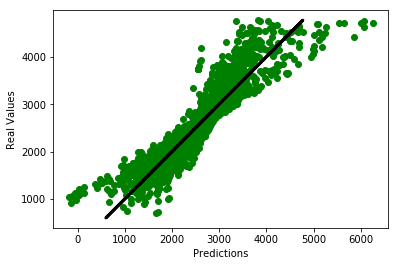

In [85]:
lr_predict = lr.predict(Xtest)
print("R2 Score: " + str(r2_score(ytest, lr_predict)))
print("EMC: " + str(mean_squared_error(ytest, lr_predict).round(decimals = 2)))

plt.scatter(lr_predict, ytest, c="green")
plt.plot(y, y, c='black', lw = 3)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.show()

R2 Score: 0.7628872000587769
EMC: 107026.88


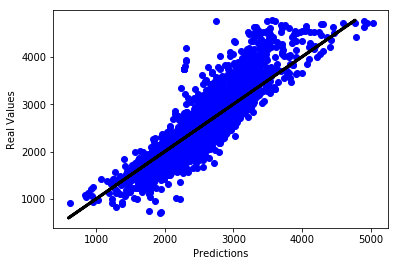

In [86]:
lmrdg_predict = lmrdg.predict(Xtest)
print("R2 Score: " + str(r2_score(ytest, lmrdg_predict)))
print("EMC: " + str(mean_squared_error(ytest, lmrdg_predict).round(decimals = 2)))

plt.scatter(lmrdg_predict, ytest, c="blue")
plt.plot(y, y, c='black', lw = 3)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.show()

R2 Score: 0.8356651432519979
EMC: 74176.71


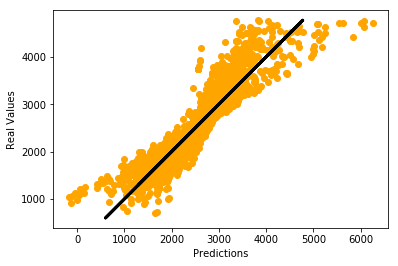

In [87]:
lmls_predict = lmls.predict(Xtest)
print("R2 Score: " + str(r2_score(ytest, lmls_predict)))
print("EMC: " + str(mean_squared_error(ytest, lmls_predict).round(decimals = 2)))

plt.scatter(lmls_predict, ytest, c="orange")
plt.plot(y, y, c='black', lw = 3)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.show()